# Assignment 4
### Do three of six.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

* Goal: Find the most effective management strategy for patients with stable istemtic heart disease, =< moderate inducible ischemia, and advanced chronic kidney disease
* Study plan
    - Two groups: Invasive vs Conservative
    - The conservative strategy was reserved for patients with OMT failure, where the more routine invasive strat was given to other more regular patients
    - This is a contingency table because it cross tabulates treatment by outcome
    - 123/388 (31.7%) Invasive 129/389 (33.2%)Conservative 
        - ~1.5% lower from invasive
    

In [1]:
import numpy as np
import matplotlib.pyplot as plt


n_inv, events_inv = 388, 123
n_con, events_con = 389, 129

surv_inv = n_inv - events_inv
surv_con = n_con - events_con

In [2]:
x_inv  = np.concatenate([np.ones(surv_inv, dtype=int),  np.zeros(events_inv, dtype=int)])
x_cons = np.concatenate([np.ones(surv_con, dtype=int),  np.zeros(events_con, dtype=int)])

In [3]:
rng = np.random.default_rng(42)
B = 20000 

boot_inv = np.empty(B)
boot_con = np.empty(B)

for b in range(B):
    boot_inv[b] = rng.choice(x_inv,  size=x_inv.size,  replace=True).mean()
    boot_con[b] = rng.choice(x_cons, size=x_cons.size, replace=True).mean()

boot_diff = boot_inv - boot_con  # invasive − conservative

In [4]:
def ecdf(a):
    v = np.sort(a)
    y = np.arange(1, v.size + 1) / v.size
    return v, y


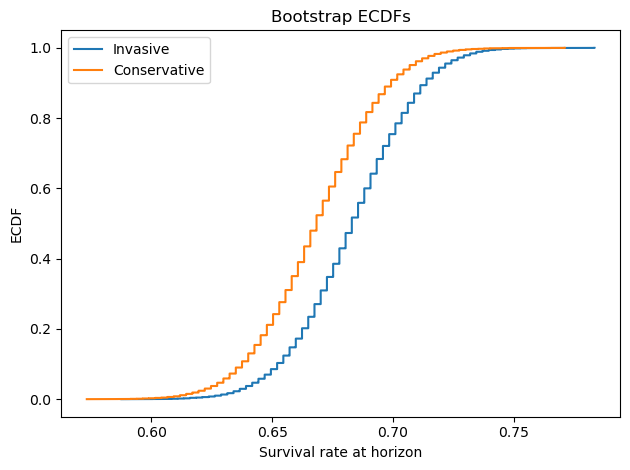

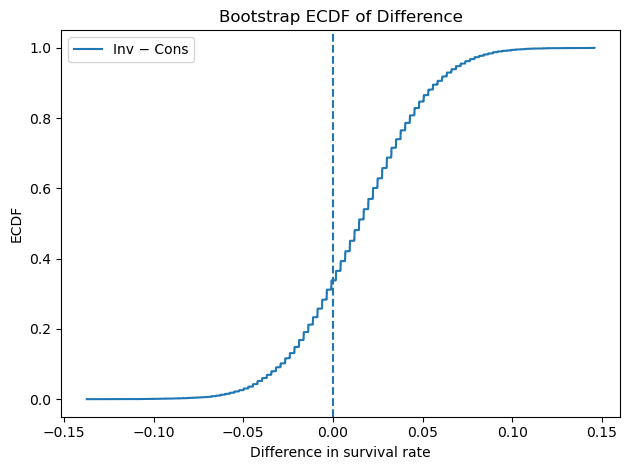

In [5]:
# ECDF of survival rates
x1,y1 = ecdf(boot_inv)
x2,y2 = ecdf(boot_con)
plt.figure(); plt.step(x1,y1,where="post",label="Invasive"); plt.step(x2,y2,where="post",label="Conservative")
plt.xlabel("Survival rate at horizon"); plt.ylabel("ECDF"); plt.legend(); plt.title("Bootstrap ECDFs"); plt.tight_layout(); plt.show()

# ECDF of difference
xd,yd = ecdf(boot_diff)
plt.figure(); plt.step(xd,yd,where="post",label="Inv − Cons"); plt.axvline(0,ls="--")
plt.xlabel("Difference in survival rate"); plt.ylabel("ECDF"); plt.legend(); plt.title("Bootstrap ECDF of Difference"); plt.tight_layout(); plt.show()


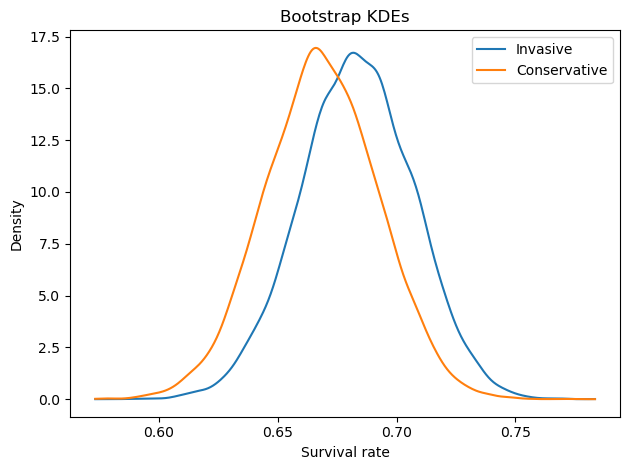

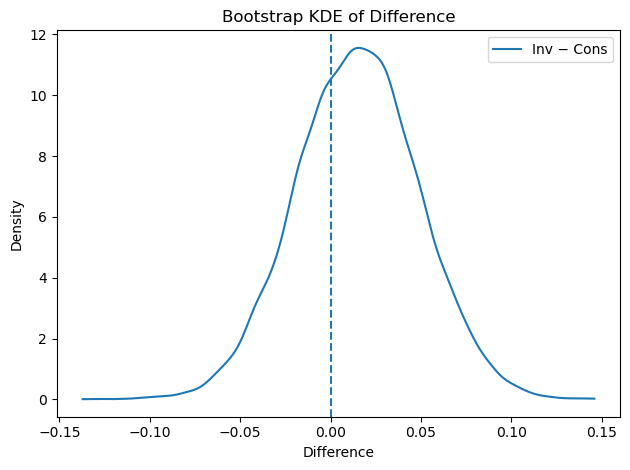

In [6]:
from scipy.stats import gaussian_kde
# KDE of survival rates
xs = np.linspace(min(boot_inv.min(), boot_con.min()), max(boot_inv.max(), boot_con.max()), 400)
plt.figure()
plt.plot(xs, gaussian_kde(boot_inv)(xs), label="Invasive")
plt.plot(xs, gaussian_kde(boot_con)(xs), label="Conservative")
plt.xlabel("Survival rate"); plt.ylabel("Density"); plt.legend(); plt.title("Bootstrap KDEs"); plt.tight_layout(); plt.show()
# KDE of difference
xd = np.linspace(boot_diff.min(), boot_diff.max(), 400)
plt.figure()
plt.plot(xd, gaussian_kde(boot_diff)(xd), label="Inv − Cons")
plt.axvline(0, ls="--"); plt.xlabel("Difference"); plt.ylabel("Density"); plt.legend(); plt.title("Bootstrap KDE of Difference"); plt.tight_layout(); plt.show()

In [8]:
def ci(a, alpha=0.05):
    return (np.quantile(a, alpha/2), np.quantile(a, 1 - alpha/2))

print("Invasive mean, 95% CI:", boot_inv.mean(),  ci(boot_inv))
print("Conservative mean, 95% CI:", boot_con.mean(), ci(boot_con))
print("Diff (Inv−Cons) mean, 95% CI:", boot_diff.mean(), ci(boot_diff))

Invasive mean, 95% CI: 0.6832289948453608 (0.6365979381443299, 0.729381443298969)
Conservative mean, 95% CI: 0.6684341902313625 (0.622107969151671, 0.7146529562982005)
Diff (Inv−Cons) mean, 95% CI: 0.014794804613998357 (-0.0522751967773567, 0.08152015477168528)


Given the fact theat the difference confidence interval is centered around zero, there does not seem to be a significant difference in survival rates

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

### Exercise 5
- Extend the `kde` class by adding a method to do bandwidth selection using a simple train-test split
- Extend the `kde` class by adding a method to do bandwidth seleciton by $k$-fold cross validation

### Exercise 6
In this exercise, you're going to do for LCLS what we just did for KDE: Pick the bandwidth 

Recall, the LCLS estimator is
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left(\frac{z-x_i}{h}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{1}{h}k\left(\frac{z-x_i}{h} \right)}.
$$
- Select two numeric variables from a data set. Split the data into training and test sets.
- Write a `predict(X_{train},Y_{train},X_{train})` function/method that takes a set of values $X_{test}$ and data $(X_{train},Y_{train})$, and computed predicted values $\hat{y}(X_{test})$ 
- Write a function/method that selects the bandwidth by **minimizing** the **mean squared error** of the squared differences between $\hat{y}(x_j)$ and $y_j$ on the test set:
$$
MSE(h) = \frac{1}{N_{test}} \sum_{j=1}^{N_{test}} (y_j - \hat{y}_{N_{train},h}(x_j))^2
$$
Be sure you understand what's happening here: The training data are used to make predictions for each test observation $x_j$, and then the prediction $\hat{y}(x_j)$ and true value $y_j$ are compared using squared difference